In [72]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display

np.random.seed(4589)
np.seterr(all="warn")

{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

In [73]:
import snippets
import utils
import LogBeliefPropagation

In [74]:
num_cws = 1000
max_iters = 1000
EbN0 = 2
code = snippets.n7k4_hamming
h = snippets.h_impulse_ising_model

rx = snippets.simulateLinearInterferenceAWGNChannelTransmission(code, EbN0, h, num_cws)
EsN0_lin =  code.r * 10**(EbN0/10)
sigma = 1 / np.sqrt(EsN0_lin) # TODO: think wether additional / sqrt(2) necessary
adjacency_matrix_ising, log_factors_ising = snippets.symbol_detection_ising_model(rx, h, sigma)
adjacency_matrix_checks = code.H
log_factors_checks = np.log(code.checknode_factors())
adjacency_matrix = np.concatenate((adjacency_matrix_ising, adjacency_matrix_checks), axis=0)

bp = LogBeliefPropagation.LogBeliefPropagation(adjacency_matrix, state_domain_size=2)

gamma = bp.gammaTrivialCBP()

/tmp/ipykernel_13083/2188821384.py:12: RuntimeWarning: divide by zero encountered in log
  log_factors_checks = np.log(code.checknode_factors())


In [75]:
var_beliefs = np.empty((num_cws, code.n, 2))
check_beliefs = np.empty((num_cws, bp.m) + bp.df_max * (2,))
iterations = np.empty(var_beliefs.shape[0])

map_assignment = np.empty((num_cws, code.n), dtype=int)

progress_bar = IntProgress(min=0, max=num_cws)
display(progress_bar)

for cw_idx in range(var_beliefs.shape[0]):
    progress_bar.value = cw_idx
    # ising log factors have dimension (factor_cnt, 2, 2), checks log factor have dimension (check_cnt, 2, 2, ..., 2)
    #                                                                                                  [-- df_max --]
    # we need to replicate the log_factors until they have the same dimensionality as the check factors
    log_factors_ising_replicated = np.zeros((log_factors_ising[cw_idx].shape[0],) + (len(log_factors_checks.shape) - 1) * (2,))
    log_factors_ising_replicated += log_factors_ising[cw_idx].reshape(log_factors_ising[cw_idx].shape + (len(log_factors_checks.shape) - 3) * (1,))
    log_factors = np.concatenate((log_factors_ising_replicated, log_factors_checks), axis=0)
    (var_beliefs[cw_idx,:], check_beliefs[cw_idx,:], iterations[cw_idx]) = bp.run_log_belief_propagation(
        max_iters=max_iters,
        rtol=1e-5,
        atol=1e-8,
        infty=1e6,
        log_factors=log_factors,
        max_product=True,
        gamma=gamma,
        damping=0.5
    )
    map_assignment[cw_idx] = bp.bruteforce_MAP(log_factors[np.newaxis,...])
converged = iterations < max_iters
converged_cnt = np.sum(converged)
print(f"{converged_cnt / num_cws * 100}% converged ({converged_cnt}/{num_cws})")
mpa_assignment = np.argmax(var_beliefs, axis=2) # decode with beliefs

IntProgress(value=0, max=1000)

74.0% converged (740/1000)


In [76]:

mpa_unequal_map = np.sum(np.logical_xor(mpa_assignment, map_assignment), axis=1) > 0
mpa_unequal_map_cnt = np.sum(mpa_unequal_map)
print(f"MPA unequal MAP {mpa_unequal_map_cnt / converged_cnt * 100} % ({mpa_unequal_map_cnt}/{converged_cnt})")

# divide into 4 cases
converged_unequal = np.logical_and(converged, mpa_unequal_map)
converged_unequal_cnt = np.sum(converged_unequal)
print(f"converged and unequal {converged_unequal_cnt / converged_cnt * 100} % ({converged_unequal_cnt}/{converged_cnt})")
converged_equal = np.logical_and(converged, np.logical_not(mpa_unequal_map))
converged_equal_cnt = np.sum(converged_equal)
print(f"converged and equal {converged_equal_cnt / converged_cnt * 100} % ({converged_equal_cnt}/{converged_cnt})")
notconverged_unequal = np.logical_and(np.logical_not(converged), mpa_unequal_map)
notconverged_unequal_cnt = np.sum(notconverged_unequal)
print(f"not converged and unequal {notconverged_unequal_cnt / (num_cws - converged_cnt) * 100} % ({notconverged_unequal_cnt}/{num_cws - converged_cnt})")
notconverged_equal = np.logical_and(np.logical_not(converged), np.logical_not(mpa_unequal_map))
notconverged_equal_cnt = np.sum(notconverged_equal)
print(f"not converged and equal {notconverged_equal_cnt / (num_cws - converged_cnt) * 100} % ({notconverged_equal_cnt}/{num_cws - converged_cnt})")

MPA unequal MAP 35.54054054054054 % (263/740)
converged and unequal 4.324324324324325 % (32/740)
converged and equal 95.67567567567568 % (708/740)
not converged and unequal 88.84615384615384 % (231/260)
not converged and equal 11.153846153846155 % (29/260)


converged unequal maximum min(abs(llr)): 10.742199751275272
converged equal minimum min(abs(llr)): 0.05657949781342264
not converged unequal maximum min(abs(llr)): 3.488317905252069
not converged equal minimum min(abs(llr)): 0.026376592066180926


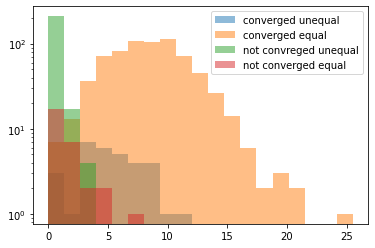

In [77]:
min_abs_llr = np.min(np.abs(var_beliefs[:,:,0] - var_beliefs[:,:,1]), axis=1)

finite_llrs = min_abs_llr[min_abs_llr < float('inf')]
if len(finite_llrs) == 0:
    raise Exception("all LLRs are infinite, plotting historgramm doesn't make sense")
max_finite_llr = np.max(finite_llrs)
min_abs_llr[min_abs_llr == float('inf')] = max_finite_llr
bins = np.linspace(0, max_finite_llr + 1, 20)

if converged_unequal_cnt > 0:
    print(f"converged unequal maximum min(abs(llr)): {np.max(min_abs_llr[converged_unequal])}")
    plt.hist(min_abs_llr[converged_unequal], bins, alpha=0.5, label="converged unequal", log=True)
if converged_equal_cnt > 0:
    print(f"converged equal minimum min(abs(llr)): {np.min(min_abs_llr[converged_equal])}")
    plt.hist(min_abs_llr[converged_equal], bins, alpha=0.5, label="converged equal", log=True)
if notconverged_unequal_cnt > 0:
    print(f"not converged unequal maximum min(abs(llr)): {np.max(min_abs_llr[notconverged_unequal])}")
    plt.hist(min_abs_llr[notconverged_unequal], bins, alpha=0.5, label="not convreged unequal", log=True)
if notconverged_equal_cnt > 0:
    print(f"not converged equal minimum min(abs(llr)): {np.min(min_abs_llr[notconverged_equal])}")
    plt.hist(min_abs_llr[notconverged_equal], bins, alpha=0.5, label="not converged equal", log=True)
plt.legend()
plt.show()